## Calculating Gower matrix for mixed variable types
- If we have a mix of continuous and categorical variables from our NLP analysis, we will have to calculate a Gower matrix in order to perform clustering. 

### Installations
pip install gower

In [11]:
import pandas as pd
import numpy as np
import gower
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.metrics import silhouette_samples, silhouette_score

from sklearn_extra.cluster import KMedoids

In [12]:
df = pd.DataFrame({'City':['Atlanta','Baltimore','Chicago','Philadelphia'],'N-gram_Phrase_occurence': [14, 35, 9,12],
                  'Requires_Comprehensive_Reporting':['1','0','1','1'], 'TF_IDF_score': [2,9,6,3]})
df.set_index('City', inplace=True)

In [13]:
df

,N-gram_Phrase_occurence,Requires_Comprehensive_Reporting,TF_IDF_score
City,,,
Atlanta,14,1,2
Baltimore,35,0,9
Chicago,9,1,6
Philadelphia,12,1,3


### Specify categorical features

In [14]:
cat_feats = ['Requires_Comprehensive_Reporting']
cat_idx = [True if x in cat_feats else False for x in df.columns]

### Create gower matrix

In [15]:
gw = gower.gower_matrix(df, cat_features=cat_idx)
gw

array([[0.        , 0.93589747, 0.25457877, 0.07326008],
       [0.93589747, 0.        , 0.8095238 , 0.91391945],
       [0.25457877, 0.8095238 , 0.        , 0.18131869],
       [0.07326008, 0.91391945, 0.18131869, 0.        ]], dtype=float32)

In [19]:
kmedoids = KMedoids(n_clusters=1, random_state=0).fit(gw)
kmedoids.labels_
kmedoids.cluster_centers_

array([[0.07326008, 0.91391945, 0.18131869, 0.        ]], dtype=float32)

In [23]:
ls = []
for i in gw:
    diff = i - kmedoids.cluster_centers_
    ls.append(diff)
ls

[array([[-0.07326008,  0.02197802,  0.07326008,  0.07326008]],
       dtype=float32),
 array([[ 0.8626374 , -0.91391945,  0.6282051 ,  0.91391945]],
       dtype=float32),
 array([[ 0.1813187 , -0.10439563, -0.18131869,  0.18131869]],
       dtype=float32),
 array([[0., 0., 0., 0.]], dtype=float32)]

In [24]:
ls[0]

array([[-0.07326008,  0.02197802,  0.07326008,  0.07326008]],
      dtype=float32)

C:\Users\dakersey\Anaconda3\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:794: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if zdir == 'x':
C:\Users\dakersey\Anaconda3\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:796: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir == 'y':
C:\Users\dakersey\Anaconda3\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:798: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir[0] == '-':


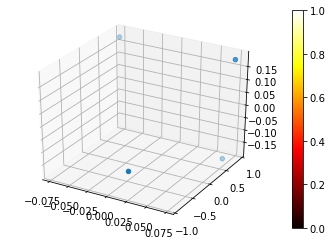

In [27]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

img = ax.scatter(ls[0], ls[1], ls[2], ls[3], cmap=plt.hot())
fig.colorbar(img)
plt.show()

### K-medoids calculations

In [66]:
def init_medoids(X, k):
    from numpy.random import choice
    from numpy.random import seed
    
    seed(1)
    samples = choice(len(X), size=k, replace=False)
    return X[samples, :]

In [67]:
meds = init_medoids(gw, 1)
meds

array([[0.10897436, 0.7115385 , 0.28846154, 0.        ]], dtype=float32)

In [68]:
def compute_d_p(X, medoids, p):
    m = len(X)
    medoids_shape = medoids.shape
    
    if len(medoids_shape) == 1:
        medoids = medoids.reshape((1,len(medoids)))
    k = len(medoids)
    
    S = np.empty((m, k))
    
    for i in range(m):
        d_i = np.linalg.norm(X[i, :] - medoids, ord=p, axis=1)
        S[i, :] = d_i**p
    
    return S

In [87]:
dists = compute_d_p(gw, meds, 2)
dists = dists.flatten()
dists

array([0.03895464, 1.74539781, 0.26446414, 0.        ])

In [92]:
cities = ['Atlanta','Baltimore','Chicago','Philadelphia']

dist = pd.DataFrame({'City': cities, 'Distance':dists})
dist['Pct'] = dist['Distance'].rank(pct=True)
dist['Is_High_Risk'] = np.where(dist['Pct'] >= 0.75, 'Yes', 'No')
dist

,City,Distance,Pct,Is_High_Risk
0,Atlanta,0.038955,0.50,No
1,Baltimore,1.745398,1.00,Yes
2,Chicago,0.264464,0.75,Yes
3,Philadelphia,0.000000,0.25,No
